<a href="https://colab.research.google.com/github/MatchaJelly/SolvePuzzle/blob/main/%5BBaseline%5D_Solve_Sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![AIcrowd-Logo](https://images.aicrowd.com/raw_images/challenges/banner_file/519/ca49f12b154ac7796282.png)

### Baseline for [Solve Sudoku Challenge](https://www.aicrowd.com/blitz/puzzles/solve-sudoku)

**Author** : Yoogottam Khandelwal

## Let's download the necessary packages

In [ ]:
import sys
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install aicrowd-cli
%load_ext aicrowd.magic

     |████████████████████████████████| 51 kB 2.5 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 1.1 MB 13.6 MB/s 
     |████████████████████████████████| 214 kB 55.5 MB/s 
     |████████████████████████████████| 170 kB 43.5 MB/s 
     |████████████████████████████████| 54 kB 2.7 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 51 kB 5.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 22.3.0
    Uninstalling pyzmq-22.3.0:
      Successfully uninstalled pyzmq-22.3.0
  Attempting uninstall: python-slugify
    Found existing installation: python-slugify 6.1.2
    Uninstalling python-slugify-6.1.2:
      Successfully uninstalled python-slugify-6.1.2
ERROR: pip's dependency resolver does not curren

In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/xZ2U4oplxEqkrs7YW1j4Y5g_OJRDPAHRkw8wUASuLYA
API Key valid
Gitlab access token valid
Saved details successfully!


## Now, let's download the challenge dataset

In [ ]:
!rm -rf data
!mkdir data
%aicrowd dataset download -c solve-sudoku -o data

sample_submission.csv:   0%|          | 0.00/435k [00:00<?, ?B/s]

test.tar.gz:   0%|          | 0.00/305M [00:00<?, ?B/s]

train.tar.gz:   0%|          | 0.00/305M [00:00<?, ?B/s]

In [ ]:
!tar xvzf data/train.tar.gz -C data/
!tar xvzf data/test.tar.gz -C data/

Streaming output truncated to the last 5000 lines.
test/images/4057.png
test/images/2029.png
test/images/2925.png
test/images/1391.png
test/images/1065.png
test/images/1688.png
test/images/3987.png
test/images/1719.png
test/images/2805.png
test/images/4818.png
test/images/0270.png
test/images/2967.png
test/images/0781.png
test/images/2480.png
test/images/2471.png
test/images/3475.png
test/images/4528.png
test/images/2158.png
test/images/0034.png
test/images/1773.png
test/images/1176.png
test/images/1313.png
test/images/2663.png
test/images/2116.png
test/images/1387.png
test/images/4560.png
test/images/2000.png
test/images/4179.png
test/images/2110.png
test/images/2282.png
test/images/4900.png
test/images/3804.png
test/images/0650.png
test/images/0451.png
test/images/4679.png
test/images/4873.png
test/images/0114.png
test/images/3794.png
test/images/4797.png
test/images/1297.png
test/images/1823.png
test/images/2921.png
test/images/2648.png
test/images/3462.png
test/images/2080.png
test

In [ ]:
## Let's map the paths to the dataset files now.

TRAINING_IMAGES_FOLDER = "data/train/images/"
TRAINING_LABELS_PATH = "data/train/labels.csv"
TEST_IMAGES_FOLDER = "data/test/images"

## And now, let's import other important packages

In [ ]:
import os
import tqdm

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

import cv2 as cv

## Defining a Helper function
A simple utility to display images read by opencv inline.

In [ ]:
def cv_imshow(img, ax=None):
    gray = False

    if len(img.shape) == 2:
        gray = True
    if img.shape == 3 and img.shape[-1] == 1:
        gray = True

    if ax is None:
        _, ax = plt.subplots()

    ax.axis("off")
    if gray:
        ax.imshow(img, cmap="gray")
    else:
        ax.imshow(img[:, :, ::-1])

## Load Data
We use OpenCV to load our images.
Here, we are creating an array where the input features are the individual "extracted" digits of the puzzle and the output features are the actual digits taken from the solution.

In [ ]:
training_labels_df = pd.read_csv(TRAINING_LABELS_PATH)

def extract_digits(img):

    """
    This function "extracts" the digits from a given sudoku image.
    It is pretty dumb and ignores the fact that almost all the images have been rotated by some angle, it simply divides the image into 81 pieces and returns them.

    The image dimensions are 300x300 which isn't divisible by 9. To ease the process of breaking it down to simple blocks,
        - The image was resized to make the dimensions divisible by 9.
        - Then, the image is divided into 81 pieces.
        - Each image would be a square with (297/9 = 33) pixels on each side.

    And then to forward this data for learning,
        - The image is flattened to give (33*33) = 1089 pixel values per digit.

    """
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # discard 3px to make size multiple of 9
    h = w = 297
    img = img[:h, :w]

    n_cols = n_rows = h // 9
    box_dimen = h // n_rows

    # cool np magic to convert to grid and then flattens it
    return (img.reshape(box_dimen, n_rows, -1, n_cols)
              .swapaxes(1, 2)
              .reshape(-1, n_rows * n_cols))

X = []
y = []

for _idx, row in tqdm.tqdm(training_labels_df.iterrows(), total=training_labels_df.shape[0]):
    filepath = os.path.join(
        TRAINING_IMAGES_FOLDER,
        f"{row.id:04d}.png"
    )
    img = cv.imread(filepath)

    data_X = extract_digits(img)
    # convert to list of chars
    data_y = list(map(int, row.solution))

    X.extend(data_X)
    y.extend(data_y)

X = np.array(X)
y = np.array(y)

# 1089 = 33*33, since each digit image was 33x33 and then got flattened
# 405000 = 81 * 5000, 81 digits per image, 5000 images
(X.shape, y.shape)

100%|██████████| 5000/5000 [00:11<00:00, 434.90it/s]


((405000, 1089), (405000,))

## Exploratory Data Analysis
Now, let's look at the images from the dataset and conduct data analysis!

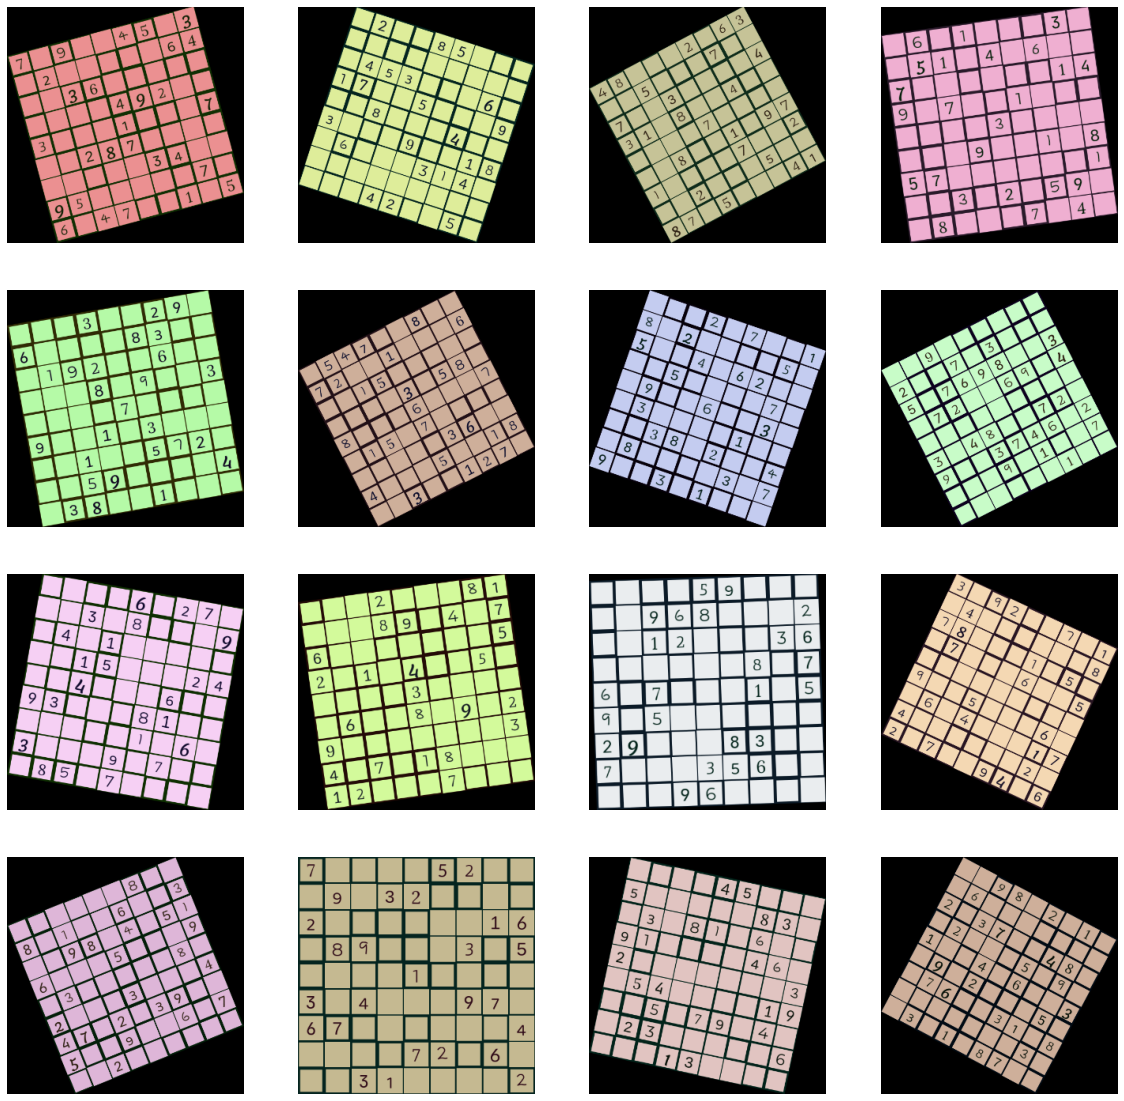

In [ ]:
plt.figure(figsize=(20,20))
for i in range(16):
    id, solution = training_labels_df.iloc[i]
    filepath = os.path.join(
        TRAINING_IMAGES_FOLDER,
        f"{id:04d}.png"
    )

    img = cv.imread(filepath)
    plt.subplot(4,4,i+1)
    plt.axis('off')
    cv_imshow(img, plt)

## Splitting Data into Train and Validation
We split the data into Training and Validation datasets to help us test the generalizability of our models and to ensure that we are not overfitting the training set.

Here we have selected the size of the testing data to be 20% of the total data. You can change it and see what effect it has on the accuracy.

To learn more about the train_test_split function [click here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

## Load Data
We use OpenCV to load our images.
Here, we are creating an array where the input features are the individual "extracted" digits of the puzzle and the output features are the actual digits taken from the solution.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Define the Classifier
Now, we can finally get to training the classifier.

Here we use sklearn [`SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [ ]:
model = SVC(max_iter=3, verbose=True, random_state=42)

"""
  NOTE:
    - This is a silly solution to this problem, and we encourage you to explore what works the best for you.
    - For example, No effort was made to remove blank cells from X
"""

'\n  NOTE:\n    - This is a silly solution to this problem, and we encourage you to explore what works the best for you.\n    - For example, No effort was made to remove blank cells from X\n'

## Train the classifier

In [ ]:
model.fit(X_train, y_train)

[LibSVM]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=3).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


SVC(max_iter=3, random_state=42, verbose=True)

## Run Predictions on the Validation Dataset
Now that we have our classifier, let's make predictions on the validation set and evaluate our model.

In [ ]:
y_pred = model.predict(X_val)

## Evaluating the model's Performance
In this puzzle, we are using [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) and [RMSE](https://www.statisticshowto.com/rmse/) to test the performance of our model.

In [ ]:
print('Mean Absolute Error:', mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, y_pred)))

Mean Absolute Error: 3.7441975308641977
Mean Squared Error: 20.351827160493826
Root Mean Squared Error: 4.511299941313349


## Clearly, the model isnt anywhere near good 😉
But, we're just getting started

1

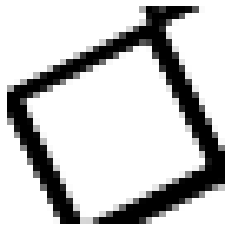

In [ ]:
cv_imshow(X_val[0].reshape(33,33))
y_pred[0]

## Load Test Set

In [ ]:
import glob

X_test = []
ids = []

for img_path in tqdm.tqdm(glob.glob(os.path.join(TEST_IMAGES_FOLDER, "*.png"))):
    img = cv.imread(img_path)
    data_X = extract_digits(img)

    X_test.extend(data_X)
    ids.append(os.path.splitext(os.path.basename(img_path))[0])

X_test = np.array(X_test)

100%|██████████| 5001/5001 [00:16<00:00, 312.12it/s]


## And now, let's make predictions on the test set

In [ ]:
y_test = model.predict(X_test)

## What did we just do?
We extracted 81 images from each file and then tried to know which digit they contain. Later, we just merge them back to form the solution.

To get a better score,
- The model will need to detect blank cells
- Construct the puzzle from the image
- And finally, we will solve that puzzle from the image

In [ ]:
y_test = y_test.reshape(-1, 81)

In [ ]:
test_df = pd.DataFrame(map(''.join, y_test.astype(str)), columns=['solution'])
test_df["id"] = ids

## Let's save our predictions to csv

In [ ]:
# Saving the pandas dataframe
!rm -rf assets
!mkdir assets
test_df.to_csv('assets/submission.csv', index=False)

**Note**: Do take a look at the submission format. The submission file should contain the following header : `id,solution`.


## Make a submission using the aicrwd-cli

In [ ]:
%aicrowd submission create -c solve-sudoku -f assets/submission.csv

Output()

╭─────────────────────────╮                                      
                                     │ Successfully submitted! │                                      
                                     ╰─────────────────────────╯

                                           Important links                                            
┌──────────────────┬─────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/solve-sudoku/submissions/182955              │
│                  │                                                                                 │
│  All submissions │ https://www.aicrowd.com/challenges/solve-sudoku/submissions?my_submissions=true │
│                  │                                                                                 │
│      Leaderboard │ https://www.aicrowd.com/challenges/solve-sudoku/leaderboards                    │
│                  │                                                                                 │
│ Discussion forum │ https://discourse.aicrowd.com/c/solve-sudoku                                    │
│                  │                                                                                 │
│   Challenge page │ https://www.aicrowd.com/challenges/solve-sudoku                                 │
└──────────────────┴─────────────────────────────────────────────────────────────────────────────────┘

{'submission_id': 182955, 'created_at': '2022-05-11T14:18:41.164Z'}
